# Portfolio with the Maximum Calmar Ratio for the Oil & Gas Sector

In [9]:
from pandas_datareader import data
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# Establishing Dates
start = "2017-01-01"
end = "2021-1-1"

# Establishing Assets
assets = ['RELIANCE.NS', 'ONGC.NS', 'BPCL.NS', 'IOC.NS',
         'GAIL.NS', 'HINDPETRO.NS', 'IGL.NS', 'PETRONET.NS', 'GUJGASLTD.NS']



#252 trading days in a year
N = 252

#1% risk free rate
rf =0.02

# Creating an empty dataframe
df_prices = pd.DataFrame()

# Getting the "Adj Close" data from Yahoo Finance by defining a function
# This function lists the price data as daily percent change 
def YahooData(dataframe, assets_list, start_date, end_date):
    for i in assets_list:
        dataframe[i] = data.DataReader(i, data_source = "yahoo", start=start_date, end=end_date)['Adj Close']
    return dataframe

# Running the function that we just made and saving the results to the DataFrame
df = YahooData(df_prices, assets, start, end)

# Calculating Log Return
df = np.log(df/df.shift(1))

# Dropping the first row because it's N/A
df = df.dropna()

# Viewing df head
df

RELIANCE.NS   ONGC.NS   BPCL.NS    IOC.NS   GAIL.NS  HINDPETRO.NS  \
Date                                                                            
2017-01-03     0.003955  0.001299  0.015569  0.052933  0.014374      0.031283   
2017-01-04    -0.020635  0.011877  0.007504 -0.006684 -0.002949     -0.007241   
2017-01-05     0.009559  0.024592  0.025977  0.027608  0.004534      0.025700   
2017-01-06    -0.002277  0.014421 -0.011738 -0.017742  0.000904     -0.013303   
2017-01-09     0.002555 -0.022720 -0.017831 -0.010303 -0.015599     -0.007960   
...                 ...       ...       ...       ...       ...           ...   
2020-12-28     0.004578  0.006954  0.013679  0.015939  0.020594      0.007229   
2020-12-29    -0.006636 -0.006954 -0.003271 -0.005468  0.008929      0.000929   
2020-12-30     0.002735  0.001073  0.003532 -0.003295 -0.005266      0.004863   
2020-12-31    -0.005125 -0.002147 -0.004581  0.000550  0.001218      0.006677   
2021-01-01     0.001107  0.001611  0.002228  0.006029  0.003240      0.015257   

              IGL.NS  PETRONET.NS  GUJGASLTD.NS  
Date                                             
2017-01-03  0.028998     0.026346      0.008924  
2017-01-04 -0.012012    -0.015217      0.001308  
2017-01-05 -0.004233     0.008630      0.001959  
2017-01-06 -0.008899    -0.011968     -0.017680  
2017-01-09 -0.000867    -0.000669      0.042354  
...              ...          ...           ...  
2020-12-28  0.001838     0.020312     -0.001598  
2020-12-29  0.042058    -0.016662      0.014950  
2020-12-30 -0.010918    -0.002026      0.003801  
2020-12-31 -0.006350     0.004453     -0.015292  
2021-01-01  0.009510     0.009046      0.004242  

[988 rows x 9 columns]

In [11]:
# Creating 10000 random simulations of each portfolio weight configuration
num_runs = 10000 # number of rows/iterations

# Creating a Matrix with 10000 rows, with each row representing a random portfolio:
    #first 3 columns are Mean Returns, Standard Deviation, and Sortino Ratio
    # remaining columns are each assets random weight within that random portfolio
result = np.zeros((num_runs,(len(assets)+3)))
result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
df = df.copy()

for i in range(num_runs):
    
    # randomized weights
    weights = np.array(np.random.random(len(assets))) 
    #Rebalance w/ constraints (SUM of all weights CANNOT BE > 1)
    weights = weights/np.sum(weights)
    
    ### daily return of the portfolio based on a given set of weights
    df['portfolio_ret'] = df.iloc[:,0]*weights[0]+df.iloc[:,1]*weights[1]+df.iloc[:,2]*weights[2]
  
                       
    # Calculating mean
    E = df['portfolio_ret'].mean()
    
    
    # Annualizing mean
    E = E*252
    

    
    # Calculating Drawdown
    def max_drawdown(return_series):
        comp_ret = (return_series+1).cumprod()
        peak = comp_ret.expanding(min_periods=1).max()
        dd = 1 - (comp_ret/peak)
        return dd.max()

    max_drawdown = max_drawdown(df['portfolio_ret'])
   
    #Calculating Annualised Calmar
    Calmar = E / max_drawdown
    
                   
    # Populating the 'result' array with the required values: Mean, Drawdown, Calmar followed by the weights                   
    result[i,0] = E
    result[i,1] = max_drawdown
    result[i,2] = Calmar
    
    for j in range(len(assets)):
        result[i,j+3]= weights[j]

In [13]:
# Converting 'result' into a DataFrame

columns = ['Mean','Drawdown', 'Calmar'] + assets

result = pd.DataFrame(result,columns=columns)
result

Mean  Drawdown    Calmar  RELIANCE.NS   ONGC.NS   BPCL.NS    IOC.NS  \
0     0.036456  0.201890  0.180572     0.146680  0.113778  0.086154  0.000792   
1     0.005997  0.225887  0.026550     0.081456  0.176293  0.101224  0.121165   
2    -0.004610  0.227866 -0.020233     0.027215  0.140531  0.190218  0.107185   
3    -0.000607  0.220425 -0.002754     0.057631  0.168335  0.112841  0.128256   
4     0.010849  0.209449  0.051799     0.063550  0.114139  0.171482  0.095267   
...        ...       ...       ...          ...       ...       ...       ...   
9995  0.059626  0.206342  0.288966     0.199220  0.076732  0.090321  0.233549   
9996  0.036004  0.139729  0.257671     0.140306  0.084190  0.007419  0.256852   
9997  0.033694  0.315504  0.106795     0.159546  0.192009  0.210692  0.092587   
9998  0.029409  0.167010  0.176089     0.074138  0.013421  0.197192  0.171850   
9999  0.027347  0.118105  0.231544     0.082947  0.025801  0.090832  0.072818   

       GAIL.NS  HINDPETRO.NS    IGL.NS  PETRONET.NS  GUJGASLTD.NS  
0     0.159659      0.085161  0.136052     0.112810      0.158913  
1     0.018322      0.159316  0.192673     0.142561      0.006990  
2     0.017189      0.285582  0.122111     0.070906      0.039061  
3     0.050010      0.235756  0.070561     0.026479      0.150129  
4     0.099623      0.020169  0.180786     0.100746      0.154238  
...        ...           ...       ...          ...           ...  
9995  0.014588      0.021720  0.160181     0.000787      0.202903  
9996  0.060108      0.158433  0.171531     0.119892      0.001269  
9997  0.106774      0.030456  0.130947     0.048966      0.028023  
9998  0.205758      0.003806  0.048186     0.064296      0.221352  
9999  0.218374      0.101006  0.195452     0.002202      0.210568  

[10000 rows x 12 columns]

In [14]:
Max_Calmar = result.iloc[result['Calmar'].idxmax()]
Max_Calmar

Mean            0.090311
Drawdown        0.151286
Calmar          0.596956
RELIANCE.NS     0.266556
ONGC.NS         0.001204
BPCL.NS         0.000696
IOC.NS          0.049464
GAIL.NS         0.217516
HINDPETRO.NS    0.155043
IGL.NS          0.093771
PETRONET.NS     0.112843
GUJGASLTD.NS    0.102907
Name: 7933, dtype: float64

In [15]:
Min_Drawdown = result.iloc[result['Drawdown'].idxmin()]
Min_Drawdown

Mean           -0.001222
Drawdown        0.017602
Calmar         -0.069429
RELIANCE.NS     0.002265
ONGC.NS         0.014547
BPCL.NS         0.001774
IOC.NS          0.120247
GAIL.NS         0.171278
HINDPETRO.NS    0.248106
IGL.NS          0.008093
PETRONET.NS     0.276617
GUJGASLTD.NS    0.157073
Name: 121, dtype: float64

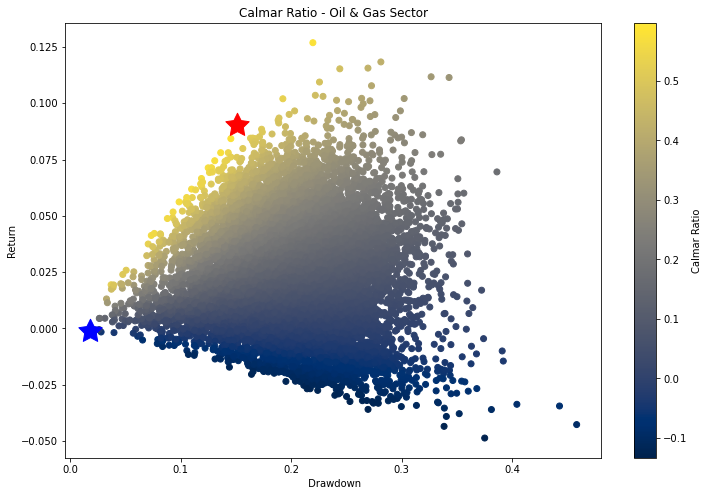

In [16]:
plt.figure(figsize=(12,8))
plt.scatter(x=result['Drawdown'],y=result['Mean'],c=result['Calmar'],cmap='cividis')
plt.colorbar(label='Calmar Ratio')
plt.xlabel(' Drawdown')
plt.ylabel('Return')

plt.title('Calmar Ratio - Oil & Gas Sector')
#Plot a red star to highlight position of the portfolio with highest Sortino Ratio
plt.scatter(Max_Calmar[1],Max_Calmar[0],marker=(5,1,0),color='r',s=600)

#Plot a blue star to highlight position of the portfolio with minimum Variance
plt.scatter(Min_Drawdown[1],Min_Drawdown[0],marker=(5,1,0),color='b',s=600)
plt.show()